# Vectorized Backtesting

## Some Imports

In [1]:
import math
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('ggplot')
from pandas_datareader import data as web
%matplotlib inline

ImportError: No module named pandas_datareader

## Retrieving & Reading the Data

In [2]:
h5 = pd.HDFStore('equities.h5', 'r')
raw = h5['data']
h5.close()

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4351 entries, 2000-01-03 to 2017-04-19
Data columns (total 7 columns):
AAPL      4351 non-null float64
MSFT      4351 non-null float64
YHOO      4351 non-null float64
^GDAXI    4297 non-null float64
^GSPC     4351 non-null float64
^VIX      4351 non-null float64
^SSMI     4274 non-null float64
dtypes: float64(7)
memory usage: 271.9 KB


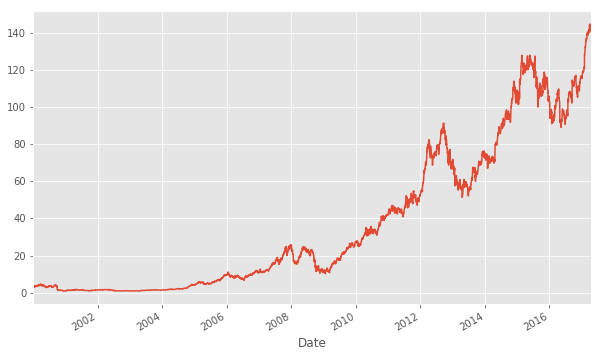

In [4]:
raw['AAPL'].plot(figsize=(10, 6));

## Strategy Training -- DNN

In [5]:
import tensorflow as tf
import itertools as it

In [6]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
class DNNVectorOptimizer(object):
    def __init__(self, symbol, start, end, tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.data = pd.DataFrame()
        self.tc = tc
        self.get_data()
    
    def get_data(self):
        h5 = pd.HDFStore('equities.h5', 'r')
        raw = h5['data']
        h5.close()
        raw_sym = pd.DataFrame(raw[self.symbol])
        self.data = raw_sym[(raw_sym.index > self.start) & (raw_sym.index <= self.end)].copy()
        self.data['log_rets'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data['returns'] = np.where(self.data['log_rets'] > 0, 1, 0)

        
    def plot_data(self):
        self.data[cols].plot(figsize=(10, 6), title=self.symbol)
        
    def prepare_data(self):
        self.cols = []
        self.fcb = None
        for lag in range(1, self.lags+1):
            col = 'lag_%d' % lag
            self.data[col] = self.data['log_rets'].shift(lag)
            self.cols.append(col)
        self.data.dropna(inplace=True)
        fc = tf.contrib.layers.real_valued_column('lags', dimension=self.lags)
        mean = self.data['log_rets'].mean()
        std = self.data['log_rets'].std()
        self.fcb = tf.contrib.layers.bucketized_column(fc, boundaries=[mean-std, mean-std/2,
                                                          mean, mean+std/2, mean+std])
        
    def input_data(self):  
        fc = {'lags': tf.constant(self.data[self.cols].values)}
        la = tf.constant(self.data['returns'].values, shape=[len(self.data), 1])
        return fc, la
        
    def run_strategy(self, lags, hidden_units, steps):
        self.lags = lags
        self.hidden_units = hidden_units
        self.steps = steps
        self.results = None
        self.prepare_data()
        data = self.data.dropna().copy()
        
        model = tf.contrib.learn.DNNClassifier(hidden_units=self.hidden_units, feature_columns=[self.fcb])
        model.fit(input_fn=self.input_data, steps=self.steps)
        model.evaluate(input_fn=self.input_data, steps=1)
        
        # core line of strategy: sentiment analysis of the position on each day
        pred = np.array(list(model.predict(input_fn=self.input_data)))
        data['position'] = np.where(pred > 0, 1, -1)
        
        data['strategy'] = data['position'] * data['log_rets']       
        data.dropna(inplace=True)

        trades = (data['position'].diff().fillna(0) != 0)
        data['strategy'] = np.where(trades, data['strategy'] - self.tc, data['strategy'])
        
        data['CReturns'] = data['log_rets'].cumsum().apply(np.exp)
        data['CStrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        return data[['CReturns', 'CStrategy']].iloc[-1]
    
    def plot_results(self):
        self.results[['CReturns', 'CStrategy']].plot(figsize=(10, 6))

In [8]:
class DNNVectorOptimizer(DNNVectorOptimizer):
    def optimize_parameters(self, lags_range, hidden_units_range):
        self.brute_force = pd.DataFrame()
        for lags, hidden_units in it.product(lags_range, hidden_units_range):
            res = self.run_strategy(lags, [hidden_units], steps=100)
            self.brute_force = self.brute_force.append(
                                     pd.DataFrame({'lags': lags, 'hidden_units': hidden_units,
                                                   'CReturns': res['CReturns'],
                                                   'CStrategy': res['CStrategy']},
                                                 index=[0]),
                                        ignore_index=True)
        return self.brute_force.iloc[self.brute_force['CStrategy'].argmax()]

## In-Sample vs. Out-of-Sample Results

In [9]:
start='2010-1-1'
cutoff='2014-1-1'
end='2017-1-1'

In [10]:
# in-sample = optimization
# AAPL MSFT YHOO ^GDAXI ^GSPC ^VIX ^SSMI    
dnni = DNNVectorOptimizer(symbol='AAPL', start='2010-1-1', end=cutoff, tc=0.00)

In [11]:
dnni.run_strategy(10, [50], 100)

CReturns      2.698199
CStrategy    20.950066
Name: 2013-12-31 00:00:00, dtype: float64

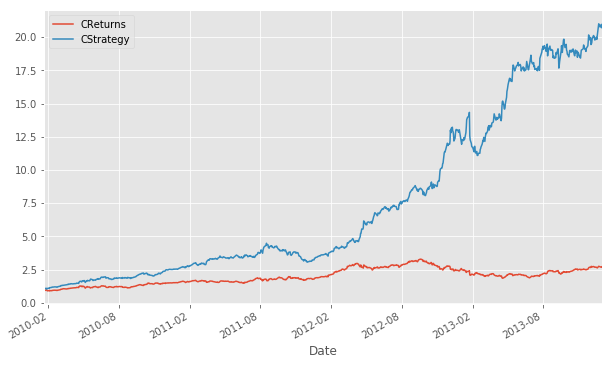

In [12]:
dnni.plot_results()

In [13]:
dnni.optimize_parameters(range(5, 25, 5), range(20, 120, 20))

CReturns         1.811152
CStrategy       53.402957
hidden_units    80.000000
lags            20.000000
Name: 18, dtype: float64

In [14]:
# out-of-sample = testing
dnno = DNNVectorOptimizer(symbol='AAPL', start=cutoff, end=end, tc=0.00)

In [15]:
dnno.run_strategy(20, [80], 100)

CReturns      1.719213
CStrategy    20.473620
Name: 2016-12-30 00:00:00, dtype: float64

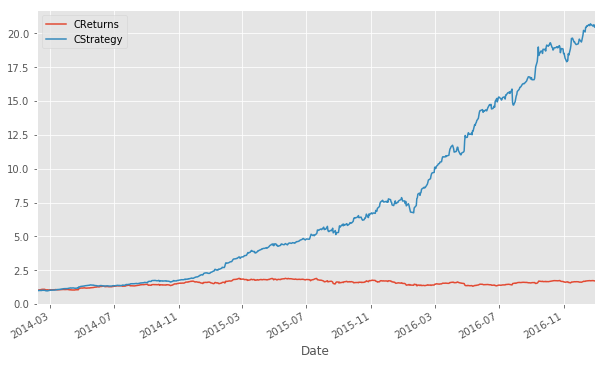

In [16]:
dnno.plot_results()

It seems that larger lags and hidden_units will lead to larger CStrategy return. Howewver, the frequence of trading also becomes larger which means much higher transaction cost will be needed. If we consider the transaction cost in our model, the CStrategy return will become very small below the CReturns.